In [1]:
# First we want to load in a halo catalog

import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home/users/kokron/Libraries/lim')
from lim import lim
import numpy as np
import astropy.units as u
from SkyLine import make_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import time
import healpy as hp
from scipy.optimize import root_scalar

# palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)

color1='#d1a862'
color2='#c38854'
color3='#9c4630'
color4='#550022'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [color1,color2,color3,color4])


plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.facecolor'] = 'w'

LC_path='/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/'
# LC_path='/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lc_fullsky'

In [2]:
def LC_params(line):
    '''
    This function is a proxy to return a dictionary with the input parameters to call SkyLine. 
    
    This function it's designed to get the same noise, resolution and redshift coverage for all lines, 
    but serves as an example for any application
    '''
    h=0.678 #Reduced Hubble constant from the lightcone. This is default, used here for h-based units
    
    #survey and experimental parameters
    zmin = 0.8;zmax = 1.0 #minimum and maximum redshift of the survey (to load lightcone slices)
    zmid=(zmax+zmin)/2 #mid redshift
    R=700 # Spectral Resolution
    ang_lim=2*u.deg #RA and DEC (total) width of the survey
    
    #line-dependent parameters
    if line=='CO':
        nu_CO=115.271*u.GHz #rest-frame frequency
        dnu=nu_CO/(1+zmid)/R #channel witdh for this case
        nuObs_max, nuObs_min = nu_CO/(1+zmin), nu_CO/(1+zmax) #The edges of the bandwith of the experiment for this case
        #values for which line to include and its model
        lines = dict(CO_J10=True) 
        target_line = 'CO_J10'
        line_models = dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                     model_pars={'alpha':0.674,'beta':4.898,'alpha_std':0,'beta_std':0,'sigma_L':0.2})) #you can add more lines to the dictionary. Structure is "dict(<line_id1>=dict(model_name=<your model>,model_pars = {<dict with the params>}), <line id2>=...)"; you only need to specify the lines included
        #whether measure intensity or temperature
        do_intensity = False
        Tsys=0*u.uK #system temperature (0 for noiseless exp). Careful with units, depends on the do_intensity    
    
    #Create the dictionary and fill it. 
    params=dict(halo_lightcone_dir=LC_path, #specify the path to the directory with the lightcone slices
                do_external_SFR = False, external_SFR = '', SFR_pars=dict(), #we use UniverseMachine SFRs, but you can input your own! Check source/external_sfrs.py 
                #which halos to load?
                zmin = zmin-0.03, zmax = zmax+0.03, #limits to load the lightcone slices. Small overhead to avoid border effects or not including a given slice..
                RA_width=ang_lim, DEC_width=ang_lim, #limits in DEC and RA width to load halos from the lightcone
                #Build the survey (line-related parameters defined above)
                lines = lines, #lines included in the survey
                target_line = target_line, #target line: used to set the redshift (interlopers define with respect to this)
                models = line_models, #models for the lines included
                LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10), #infrared luminoisity model
                do_intensity = do_intensity, #using intensity or brightness temperature?
                do_remove_mean=True, #We can't measure the mean temperature -> removed from sky subtraction
                RAObs_width=ang_lim, DECObs_width=ang_lim, #limits in DEC and RA width for the survey
                nuObs_max= nuObs_max,nuObs_min =nuObs_min, #The edges of the bandwith of the experiment
                #experimental noise and resoultion
                Nfeeds=1000, #number of detectors
                tobs=6000*u.hr, # total observing time
                dnu = dnu, #channel width
                beam_FWHM=2*u.arcmin, #beam FWHM 
                #do you want to apply the smoothing kernels to mock experimental resolution?
                do_angular_smooth=True, do_spectral_smooth=True,
                # precision parameters
                resampler='cic', #mass asignment filter
                angular_supersample=4, spectral_supersample=4, #angular and spectral supersample (with respect to the experimental resolutions in physical)
                do_downsample=True, # do you want to downsample back to 1 voxel / resolution element (after smoothing by the experimental resolution kernels)
                cube_mode='inner_cube', #how do you want so cut your observed cube. Inner_cube is the safest for now
                Nmu=30, #Number of bins in mu = k/k_par to compute the power spectrum multipoles
                dk=0.02*u.Mpc**-1, # bin size in the k vector for the power spectrum
                kmin=0.*u.Mpc**-1,kmax=1*u.Mpc**-1, #min and max k value for the power spectrum
                seed=0) #seed for the RNG. 
                
    return params

In [3]:
nside = 512
dz = 0.1
LC_CO = make_measurements(LC_params('CO'))

#We take the middle channel for now as nu for SED?
nu_sed = LC_CO.nuObs_mean

#
z_sed = LC_CO.zmid

def Zgas(halocat):
    '''
    Computes the gas metallicity of each halo in the catalog
    
    '''
    mstars = halocat['SM_HALO']
    
    sfrs = halocat['SFR_HALO']
    
    y = np.log10(mstars) - 0.6 * np.log10(sfrs) - 10
    
    zgas = 8.80 + 0.188*y - 0.220 * y**2 - 0.0531 * y ** 3
    
    return zgas

def mainsequence_ssfr(halocat):
    '''
    Computes the main sequence specific star formation rate for each halo. 
    This requires an implementation of "cosmic time" given z 
    
    defined in page 3 of https://browse.arxiv.org/pdf/1702.01140.pdf
    
    '''
    
    logz = np.log10(1 + halocat['Z'])
    
    #Get cosmic time of each halo for this specific calibrated fit
    logtc = 1.143 - 1.026 * logz - 0.599 * logz**2 + 0.528 * logz**3
    
    tc = 10**logtc
    
    logmstar = np.log10(halocat['SM_HALO'])
    
    log10ssfr = (-0.16 - 0.026*tc) * (logmstar + 0.025) - (6.51 - 0.11*tc) + 9
    
    return 10**log10ssfr

def MgasToMstar(halocat):
    '''
    Gas-to-stellar mass ratio for a halo with SFR and SM
    '''
    A = 0.06
    B = -2.30
    F = 0.65
    C = 0.51
    D = -0.41

    ssfr = halocat['SFR_HALO']/halocat['SM_HALO']
    
    ms_ssfr = mainsequence_ssfr(halocat)
    
    Delta_MS = ssfr / ms_ssfr
    
    log10mgas = A + B * (np.log10(1 + halocat['Z']) - F)**2 + C*np.log10(Delta_MS) + D*(np.log10(halocat['SM_HALO'] - 10.7))

    
    return 10**log10mgas

def fz(halocat):
    '''
    Computes the redshift dependent suppression of dust to stellar mass
    
    f(z) = {1 if z < 2
            (1 - 0.05*z)^alpha if z >=2 }
    where the best fit alpha is -2.31
    '''
    alpha = -2.31
    
    zs = halocat['Z']
    
    farr = np.ones_like(zs)
    
    zidx = np.where(zs > 2)
    
    
    farr[zidx] = (1 - 0.05*zs[zidx])**alpha
    
    return farr
def Mdust(halocat):
    '''
    What is the normalization here?? Eqn 7 in the draft is a \propto
    
    '''
    ratio = MgasToMstar(halocat)
    zgas = Zgas(halocat)
    
    
    fzs = fz(halocat)
    
    Mdust = halocat['SM_HALO'] * ratio* zgas * fzs
    
    return Mdust

    

In [4]:
sys.path.append('../../preLIMinary/source/')

from line_models import LIR, lines_included

In [5]:
seed = 0

rng = np.random.default_rng(seed)

#Taking values from Yuuki's paper
LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.63, alpha_IRX=1.37, sigma_IRX=0.2,
            K_IR=1.38e-10, K_UV=1.53e-10)

LIRvec = LIR([], LC_CO.halo_catalog_all, LC_CO.halo_catalog_all['SFR_HALO'], LIR_pars, rng)

In [6]:
mdust = Mdust(LC_CO.halo_catalog_all)

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log10
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in subtract


In [7]:
ms_ssfr = mainsequence_ssfr(LC_CO.halo_catalog_all)

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10


In [8]:
def analytic_msssfr(Mstar, z=3):
    
    logz = np.log10(1 + z)
    
    #Get cosmic time of each halo for this specific calibrated fit
    logtc = 1.143 - 1.026 * logz - 0.599 * logz**2 + 0.528 * logz**3
    
    tc = 10**logtc
    
    logmstar = np.log10(Mstar)
    
    log10ssfr = (-0.16 - 0.026*tc) * (logmstar + 0.025) - (6.51 - 0.11*tc) + 9
    
    return log10ssfr

Text(0, 0.5, '$\\log_{10} (sSFR_{MS})$')

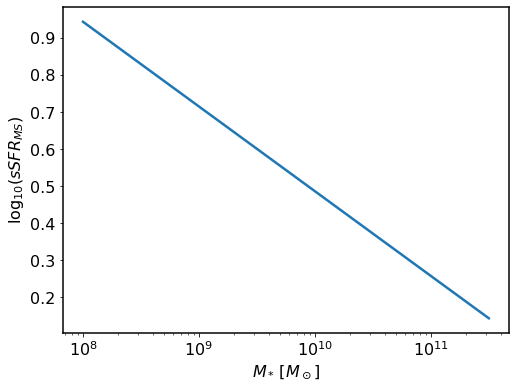

In [9]:
mstar = 10**np.linspace(8, 11.5, 100)


plt.semilogx(mstar, analytic_msssfr(mstar))
plt.xlabel(r'$M_*\, [M_\odot]$')
plt.ylabel(r'$\log_{10} (sSFR_{MS})$')

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


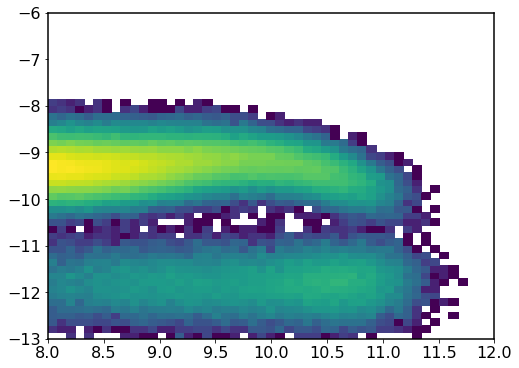

In [10]:
xbins = np.linspace(8, 12, 50)
ybins = np.linspace(-13, -6, 50)
from matplotlib.colors import LogNorm

plt.hist2d(np.log10(LC_CO.halo_catalog_all['SM_HALO']+1e-12),  y=np.log10(LC_CO.halo_catalog_all['SFR_HALO']/LC_CO.halo_catalog_all['SM_HALO']),
          bins = [xbins,ybins], norm=LogNorm());

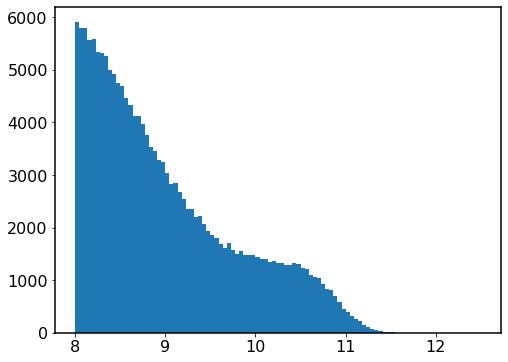

In [11]:
bins = np.linspace(8, 12.5, 100)
plt.hist(np.log10(LC_CO.halo_catalog_all['SM_HALO']+1e-12), bins=bins);

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/users/kokron/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/users/kokron/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


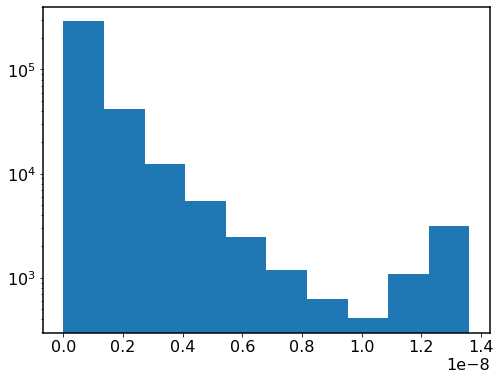

In [12]:
# bins = np.linspace(0, 10, 100)
plt.hist((LC_CO.halo_catalog_all['SFR_HALO']/LC_CO.halo_catalog_all['SM_HALO']));
# plt.hist(ms_ssfr)
plt.yscale('log')

(array([   194.,   5195.,  11456.,   5587.,  13192., 115114., 146200.,
         45479.,  12290.,   2565.]),
 array([-10.478538 , -10.014168 ,  -9.549797 ,  -9.085427 ,  -8.621057 ,
         -8.156687 ,  -7.6923165,  -7.2279463,  -6.7635765,  -6.2992063,
         -5.834836 ], dtype=float32),
 <a list of 10 Patch objects>)

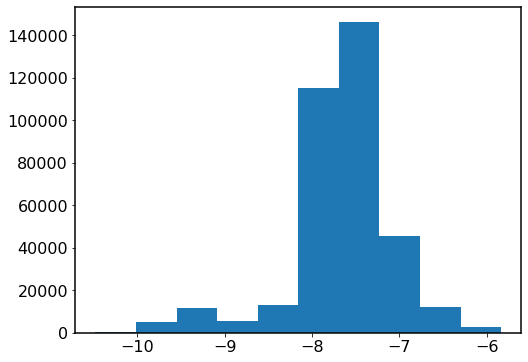

In [13]:
plt.hist(np.log10(mdust/LC_CO.halo_catalog_all['SM_HALO']))

In [14]:
zeta_d = 1.25
A = zeta_d * 125
Ad = 33.96

B = 5





def rootfind(beta, i):
    halo_LIR = LIRvec[i]
    halo_Mdust = mdust[i]

    C = halo_LIR/halo_Mdust 
    
    return A/beta - B - Ad*C**(1./(4+beta))


[]

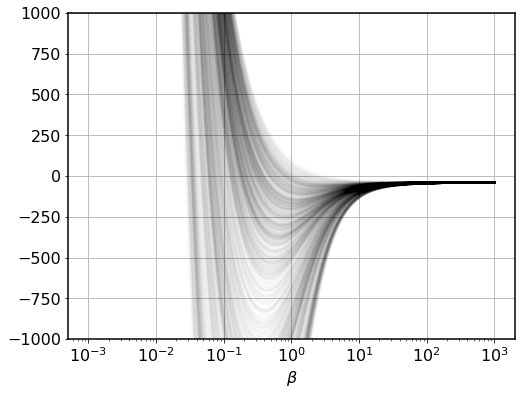

In [15]:
betavec = np.logspace(-3, 3, 1000)

# plt.plot(betavec, A/betavec - B, label=r'$A \beta^{-1} - B$')
# plt.plot(betavec, Ad*C**(1./(4+betavec)), label=r'$A_d \left ( \frac{L_{IR}}{M_{dust}} \right )^{1/(4+\beta)}$')
for i in range(1000):
    plt.plot(betavec, rootfind(betavec, i), color='k', alpha=0.01)

# plt.ylim(0, 5020)
plt.ylim(-1000, 1000)
plt.grid()
# plt.xlim(0, 1)
# plt.legend()
plt.xlabel(r'$\beta$')
plt.semilogx()
# plt.xlim()

Text(0.5, 0, '$T_{\\rm dust}\\,[K]$')

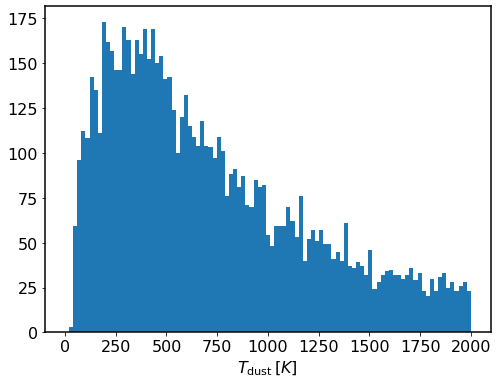

In [16]:
N=10000
dustvec = np.zeros(N)
bins = np.linspace(0, 2000, 100)

for i in range(N):
    res = root_scalar(rootfind, args=i, bracket=[1e-4, 10], method='bisect').root
    
    dustvec[i] = Ad * (LIRvec[i]/mdust[i])**(1/(4+res))
plt.hist(dustvec, bins=bins)
plt.xlabel(r'$T_{\rm dust}\,[K]$')